In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

In [2]:
def load_lammps_dump(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the number of particles
    for i, line in enumerate(lines):
        if line.startswith('ITEM: NUMBER OF ATOMS'):
            num_particles = int(lines[i+1].strip())
            break
        
        # Find the box dimensions
    for i, line in enumerate(lines):
        if line.startswith('ITEM: BOX BOUNDS'):
            box_bounds = [list(map(float, bounds.split())) for bounds in lines[i+1:i+4]]
            break

    # Find the starting line of the atomic positions
    start_lines = []
    for i, line in enumerate(lines):
        if line.startswith('ITEM: ATOMS'):
            start_line = i + 1
            start_lines.append(start_line)

    # Initialize arrays to store the data
    ntime = len(start_lines)
    positions = np.zeros((ntime, num_particles, 3))
    atom_ids = np.zeros(num_particles, dtype=int)
    atom_types = np.zeros(num_particles, dtype=int)
    
    # atom id and type
    start_line_0 = start_lines[0]
    for i in range(num_particles):
        line = lines[start_line_0+i]
        data = line.split()
        atom_ids[i] = int(data[0])
        atom_types[i] = int(data[1])

    # Parse the atomic positions, atom IDs, and atom types
    for it, start_line_t in tqdm(enumerate(start_lines)):
        for i in range(num_particles):
            line = lines[start_line_t+i]
            data = line.split()
            positions[it, i, :] = [float(data[2]), float(data[3]), float(data[4])]

    return positions, atom_ids, atom_types, box_bounds


In [3]:
# positions_list = []
# temperature_list = [810,870,910,950]
# for temp in temperature_list:
#     positions, atom_ids, atom_types, box_bounds = load_lammps_dump(f"./out_vacancy_cube8_{temp:d}_lt.dump")
#     print(positions.shape)
#     positions_list.append(positions)    

In [4]:
# positions_list_st = []
# temperature_list = [810,870,910,950]
# for temp in temperature_list:
#     positions, atom_ids, atom_types, box_bounds = load_lammps_dump(f"./out_vacancy_cube8_{temp:d}_st.dump")
#     print(positions.shape)
#     positions_list_st.append(positions)    

In [5]:
# n_t0 = 2
# n_times = positions_list[0].shape[0]
# n_times_msd = int(np.floor(n_times/n_t0))

# n_particles = len(atom_ids)


# t_list = np.arange(n_times_msd)
# t0_list = np.arange(n_t0)*n_times_msd

# msd_list = []
# for positions in positions_list:
#     msd = np.zeros(n_times_msd)
#     for it0, t0 in enumerate(t0_list):
#         position_0 = positions[t0]
#         for it, t in (enumerate(t_list)):
#             position_t = positions[t0+t]
#             msd_t = np.sum((position_t-position_0)**2)/n_particles
#             msd[it] += msd_t    
#     msd = msd/n_t0
#     msd_list.append(msd)


In [6]:
# n_t0 = 2
# n_times = positions_list_st[0].shape[0]
# n_times_msd = n_times_msd = int(np.floor(n_times/n_t0))

# n_particles = len(atom_ids)


# t_list_st = np.arange(n_times_msd)
# t0_list = np.arange(n_t0)*n_times_msd

# msd_list_st = []
# for positions in positions_list_st:
#     msd = np.zeros(n_times_msd)
#     for it0, t0 in enumerate(t0_list):
#         position_0 = positions[t0]
#         for it, t in (enumerate(t_list_st)):
#             position_t = positions[t0+t]
#             msd_t = np.sum((position_t-position_0)**2)/n_particles
#             msd[it] += msd_t    
#     msd = msd/n_t0
#     msd_list_st.append(msd)


In [7]:
temperature_list = [810,870,910,950]
n_times_msd = 5000
t_list = np.arange(n_times_msd)
t_list_st = np.arange(n_times_msd)
from scipy.io import savemat, loadmat
# msd_list = np.array(msd_list)
# msd_list_st = np.array(msd_list_st)
# mdic = {"msd_list": msd_list, "msd_list_st": msd_list_st}
# savemat("MD_msd_list.mat", mdic)
data = loadmat("MD_msd_list.mat")
msd_list = data["msd_list"]
msd_list_st = data["msd_list_st"]

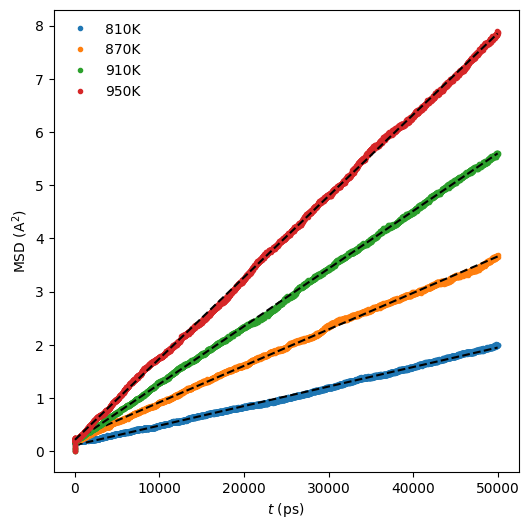

In [8]:
timestep = 10
timestep_st = 10/1000
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

colors = ["C0","C1","C2","C3"]
diffusivity_list = []
for i_temp, temperature in enumerate(temperature_list):
    msd_st = msd_list_st[i_temp]
    ax.plot(t_list_st[1:]*timestep_st,msd_st[1:],".",color=colors[i_temp])
    msd = msd_list[i_temp]
    ax.plot(t_list[1:]*timestep,msd[1:],".",color=colors[i_temp], label=str(temperature)+"K")

    # do curve fitting to get slope
    x = np.vstack([t_list[1:]*timestep,np.ones_like(t_list[1:]*timestep)]).T 
    y = msd[1:]
    A, B = np.linalg.lstsq(x, y, rcond=None)[0]    
    ax.plot(t_list[1:]*timestep, A*t_list[1:]*timestep+B, "--k")
    diffusivity_list.append(A/6)
diffusivity_list = np.array(diffusivity_list)

# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_ylim([1e-1,10])
# ax.set_xlim([1,1e4])

ax.set_xlabel(r"$t\ \rm{(ps)}$")
ax.set_ylabel(r"$\rm{MSD}\ (A^2)$")
ax.legend(frameon=False)
plt.show()

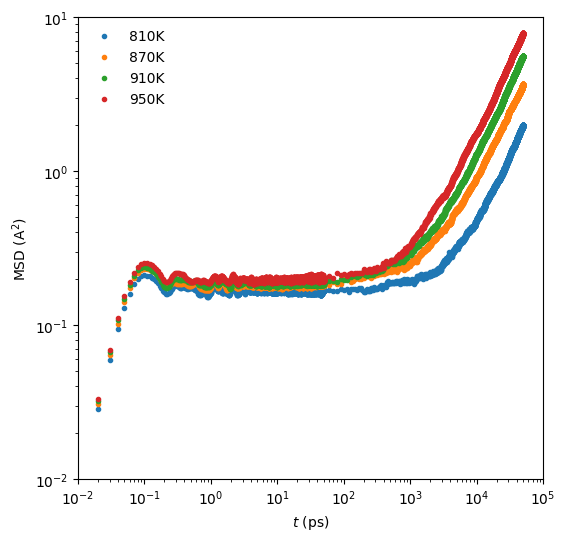

In [9]:
timestep = 10
timestep_st = 10/1000
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

colors = ["C0","C1","C2","C3"]
diffusivity_list = []
for i_temp, temperature in enumerate(temperature_list):
    msd_st = msd_list_st[i_temp]
    ax.plot(t_list_st[1:]*timestep_st,msd_st[1:],".",color=colors[i_temp])
    msd = msd_list[i_temp]
    ax.plot(t_list[1:]*timestep,msd[1:],".",color=colors[i_temp], label=str(temperature)+"K")

    # do curve fitting to get slope
    x = np.vstack([t_list[1:]*timestep,np.ones_like(t_list[1:]*timestep)]).T 
    y = msd[1:]
    A, B = np.linalg.lstsq(x, y, rcond=None)[0]    
    # ax.plot(t_list[1:]*timestep, A*t_list[1:]*timestep+B, "--k")
    diffusivity_list.append(A/6)
diffusivity_list = np.array(diffusivity_list)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-2,10])
ax.set_xlim([1e-2,1e5])

ax.set_xlabel(r"$t\ \rm{(ps)}$")
ax.set_ylabel(r"$\rm{MSD}\ (A^2)$")
ax.legend(frameon=False)
plt.show()

slope = -7920.4766K
activation energy = 0.6825 eV
pre-exponential factor (D0) = 1.0642e-01 A^2/ps


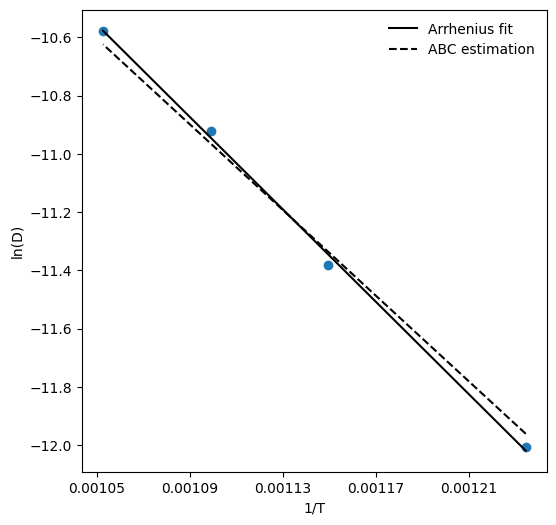

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

colors = ["C0","C1","C2","C3"]
inv_temperature_list = 1/np.array(temperature_list)
ax.plot((inv_temperature_list), np.log(diffusivity_list), "o")

# do curve fitting to get slope
x = np.vstack([inv_temperature_list,np.ones_like(inv_temperature_list)]).T 
y = np.log(diffusivity_list)
A, B = np.linalg.lstsq(x, y, rcond=None)[0]    
ax.plot(inv_temperature_list, A*inv_temperature_list+B, "-k", label = "Arrhenius fit")

k_B = 8.61733326e-5

print(f"slope = {A:0.4f}K")
print(f"activation energy = {-A*k_B:0.4f} eV")

ax.set_xlabel(r"1/T")
ax.set_xticks([0.00105,0.00109,0.00113,0.00117,0.00121,0.00125])
ax.set_ylabel(r"ln(D)")

## Estimate the pre-exponential factor
D_0 = np.exp(np.mean(np.log(diffusivity_list)) + np.mean(-A*inv_temperature_list))
print(f"pre-exponential factor (D0) = {D_0:.4e} A^2/ps")

# activation energy according to ABC
E_abc = 0.6328

# Estimate diffusivity for the given temperatures
diffusivity_estimates = np.exp(-E_abc/(k_B)*(inv_temperature_list-np.mean(inv_temperature_list))) * np.exp(np.mean(np.log(diffusivity_list)))
ax.plot(inv_temperature_list, np.log(diffusivity_estimates), "--k", label = "ABC estimation")

ax.legend(frameon=False)

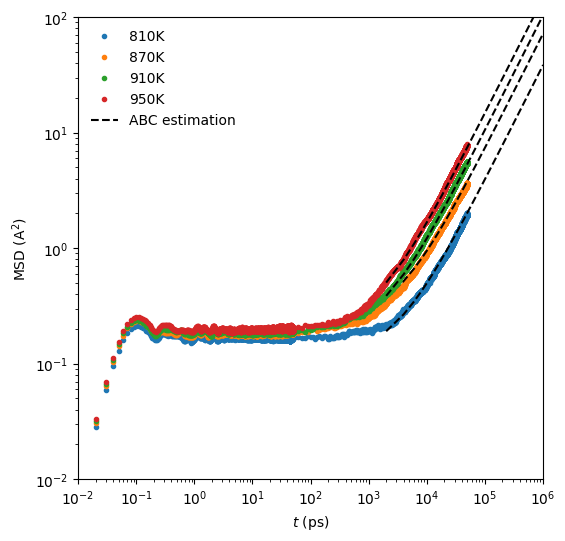

In [11]:
timestep = 10
timestep_st = 10/1000
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

colors = ["C0","C1","C2","C3"]
diffusivity_list = []
for i_temp, temperature in enumerate(temperature_list):
    msd_st = msd_list_st[i_temp]
    ax.plot(t_list_st[1:]*timestep_st,msd_st[1:],".",color=colors[i_temp])
    msd = msd_list[i_temp]
    ax.plot(t_list[1:]*timestep,msd[1:],".",color=colors[i_temp], label=str(temperature)+"K")

    # do curve fitting to get slope
    x = np.vstack([t_list[1:]*timestep,np.ones_like(t_list[1:]*timestep)]).T 
    y = msd[1:]
    A, B = np.linalg.lstsq(x, y, rcond=None)[0]    
    # ax.plot(t_list[1:]*timestep, A*t_list[1:]*timestep+B, "--k")
    
    label = "ABC estimation" if i_temp==len(temperature_list)-1 else None
    ax.plot(t_list[1:]*timestep*200, 6*diffusivity_estimates[i_temp]*t_list[1:]*timestep*200+B, "--",color="k", label = label)
    diffusivity_list.append(A/6)
diffusivity_list = np.array(diffusivity_list)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-2,100])
ax.set_xlim([1e-2,1e6])

ax.set_xlabel(r"$t\ \rm{(ps)}$")
ax.set_ylabel(r"$\rm{MSD}\ (A^2)$")
ax.legend(frameon=False)
plt.show()

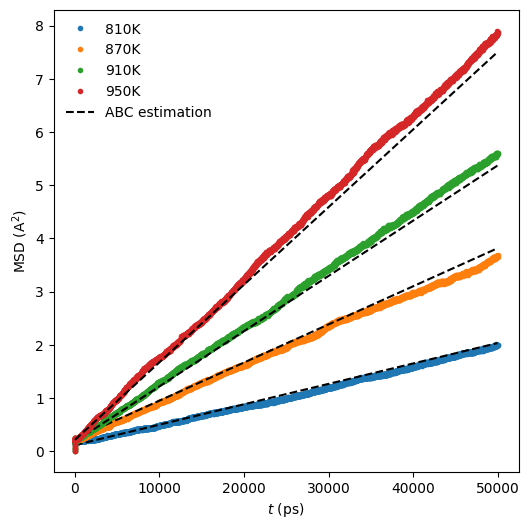

In [12]:
timestep = 10
timestep_st = 10/1000
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

colors = ["C0","C1","C2","C3"]
diffusivity_list = []
for i_temp, temperature in enumerate(temperature_list):
    msd_st = msd_list_st[i_temp]
    ax.plot(t_list_st[1:]*timestep_st,msd_st[1:],".",color=colors[i_temp])
    msd = msd_list[i_temp]
    ax.plot(t_list[1:]*timestep,msd[1:],".",color=colors[i_temp], label=str(temperature)+"K")

    # do curve fitting to get slope
    x = np.vstack([t_list[1:]*timestep,np.ones_like(t_list[1:]*timestep)]).T 
    y = msd[1:]
    A, B = np.linalg.lstsq(x, y, rcond=None)[0]    
    # ax.plot(t_list[1:]*timestep, A*t_list[1:]*timestep+B, "--k")
    
    label = "ABC estimation" if i_temp==len(temperature_list)-1 else None
    ax.plot(t_list[1:]*timestep, 6*diffusivity_estimates[i_temp]*t_list[1:]*timestep+B, "--",color="k", label = label)
    diffusivity_list.append(A/6)
diffusivity_list = np.array(diffusivity_list)

# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_ylim([1e-2,100])
# ax.set_xlim([1e-2,1e6])

ax.set_xlabel(r"$t\ \rm{(ps)}$")
ax.set_ylabel(r"$\rm{MSD}\ (A^2)$")
ax.legend(frameon=False)
plt.show()